# Filter POP data with large coarsening factor (0.1 --> 5 degree)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar

## Open POP 0.1 degree data

In [2]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### The only loaded time slice is a 5-day average

In [3]:
ds['time_bound'].values

array([[12370., 12375.]])

### Make ocean ("wet") mask for U points

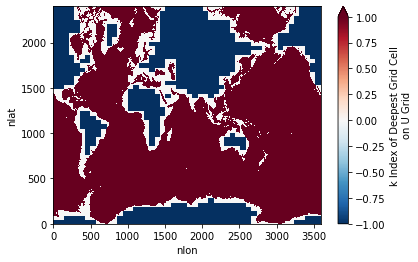

In [4]:
ds.KMU.plot(vmin=ds.KMU.min())

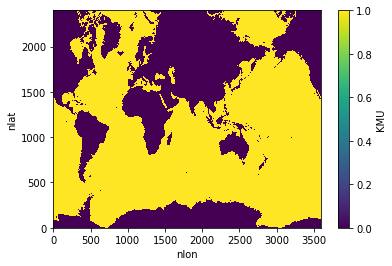

In [5]:
wetu_mask = xr.where(ds['KMU']>0,1,0)
wetu_mask.plot()

In [6]:
UVEL0 = ds['UVEL'].isel(z_t=0)
UVEL0 = xr.where(wetu_mask==1,UVEL0,np.nan)
VVEL0 = ds['VVEL'].isel(z_t=0)
VVEL0 = xr.where(wetu_mask==1,VVEL0,np.nan)

## Kinetic energy (of surface level)
$$
KE = u^2 + v^2
$$
Here, (u,v) are velocities in any locally orthogonal basis system. So either (UVEL,VVEL) or (zonVEL,merVEL) can be used, and lead to the same result.

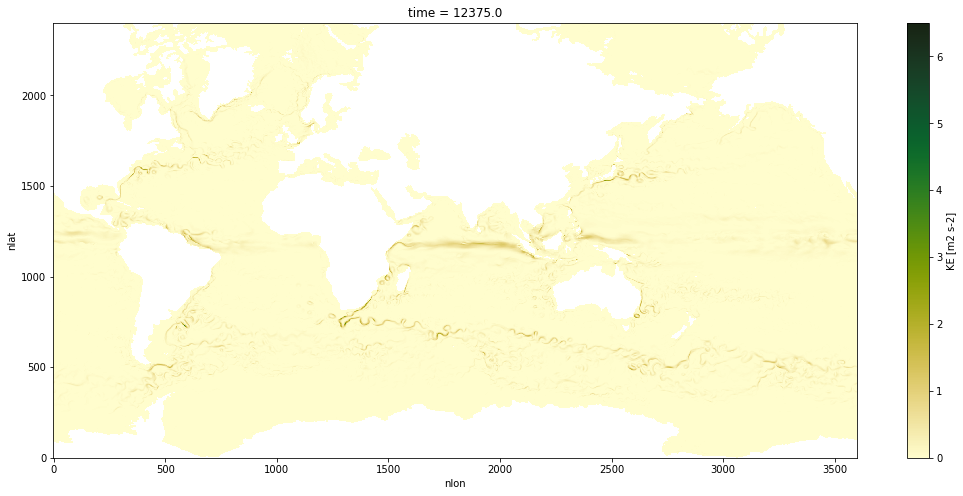

In [7]:
ds['KE'] = UVEL0**2 + VVEL0**2
(0.0001*ds['KE']).plot(figsize=(18,8),cmap=cmocean.cm.speed, cbar_kwargs={"label": 'KE [m2 s-2]'})

# Define filter

In [8]:
from scipy import interpolate
from scipy import integrate

def filterSpec(N,dxMin,Lf,shape="Gaussian",X=np.pi):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    X is the width of the transition region in the "Taper" filter; per the CPT Bar&Prime doc the default is pi.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    sL is s_i for the Laplacian steps; units of sL are one over the units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    sB is s_i for the Biharmonic steps; units of sB are one over the units of dxMin and Lf, squared
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(np.pi/(X*Lf))**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    #x = np.linspace(-1,1,251)
    x = np.linspace(-1,1,10000)
    k = np.sqrt((sMax/2)*(x+1))
    #params = {'legend.fontsize': 'x-large',
    #     'axes.labelsize': 'x-large',
    #     'axes.titlesize':'x-large',
    #     'xtick.labelsize':'x-large',
    #     'ytick.labelsize':'x-large'}
    #pylab.rcParams.update(params)
    plt.plot(k,F(x),'g',label='target filter',linewidth=4)
    plt.plot(k,np.polynomial.chebyshev.chebval(x,p),'m',label='approximation',linewidth=4)
    #plt.xticks(np.arange(5), ('0', r'$1/\Delta x$', r'$2/\Delta x$',r'$3/\Delta x$', r'$4/\Delta x$'))
    plt.axvline(1/Lf,color='k',linewidth=2)
    plt.axvline(np.pi/Lf,color='k',linewidth=2)
    #plt.text(1/Lf, 1.15, r'$\frac{1}{2}$',fontsize=20)
    #plt.text(np.pi/Lf, 1.15, r'$\frac{\pi}{2}$',fontsize=20)
    left, right = plt.xlim()
    plt.xlim(left=0)
    bottom,top = plt.ylim()
    plt.ylim(bottom=-0.1)
    plt.ylim(top=1.1)
    plt.xlabel('k', fontsize=18)
    plt.grid(True)
    plt.legend()
    #plt.savefig('figures/filtershape_%s%i_dxMin%i_Lf%i.png' % (shape,N,dxMin,Lf),dpi=400,bbox_inches='tight',pad_inches=0)
    
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # convert back to s in [0,sMax]
    s = (sMax/2)*(r+1)
    # Separate out the real and complex roots
    NL = np.size(s[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    sL = np.real(s[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    sB_re,indices = np.unique(np.real(s[np.where(np.abs(np.imag(r)) > 1E-12)]),return_index=True)
    sB_im = np.imag(s[np.where(np.abs(np.imag(r)) > 1E-12)])[indices]
    sB = sB_re + sB_im*1j
    return NL,sL,NB,sB

In [9]:
try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

**Note**: The following Laplacian assumes periodic boundary conditions. For the global POP data, this is the correct assumption in x-direction. For the y-direction, this is incorrect. Rather than communicating with the southern boundary, the POP tripolar grid **requires communication along the northern boundary of the grid** in order to “sew up” the grid along the line between the two northern grid poles. **This remains to be implemented!** The following Laplacian does the right thing away from the Arctic.

In [10]:
def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

In [11]:
def apply_filter(field, wetMask, NL, sL, NB, sB):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL[i])*tempL # Update filtered field
    for i in range(NB): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB[i])/np.abs(sB[i])**2)*tempL + (1/np.abs(sB[i])**2)*tempB
        
    return fieldBar

# Filter 2D fields: 0.1 degree --> 5 degree

In [12]:
filter_fac = 50

We will test out different choices of N.

# Laplacian steps: 98; # Biharmonic steps: 1


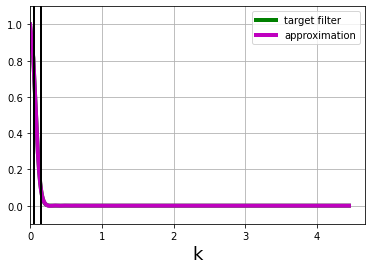

In [13]:
N=100

Lf = filter_fac/np.sqrt(6) 
NL100, sL100, NB100, sB100 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL100) + '; # Biharmonic steps: ' + str(NB100))

In [14]:
sL100

array([ 0.06503577,  0.09344805,  0.1408185 ,  0.19682017,  0.26204158,
        0.33642609,  0.41991501,  0.51244055,  0.61392593,  0.72428543,
        0.84342437,  0.97123912,  1.10761713,  1.25243692,  1.40556821,
        1.56687197,  1.73620053,  1.91339776,  2.09829919,  2.29073221,
        2.49051626,  2.69746303,  2.91137666,  3.13205399,  3.35928477,
        3.59285193,  3.83253178,  4.0780943 ,  4.32930336,  4.58591702,
        4.84768775,  5.11436273,  5.3856841 ,  5.66138925,  5.94121105,
        6.22487821,  6.51211549,  6.802644  ,  7.09618151,  7.39244271,
        7.69113953,  7.99198141,  8.29467556,  8.59892735,  8.9044405 ,
        9.21091744,  9.51805959,  9.82556767, 10.13314194, 10.4404826 ,
       10.74729   , 11.05326495, 11.35810907, 11.66152501, 11.96321682,
       12.26289016, 12.56025265, 12.85501416, 13.14688705, 13.43558647,
       13.72083069, 14.00234129, 14.2798435 , 14.55306646, 14.82174345,
       15.08561218, 15.34441507, 15.59789945, 15.84581783, 16.08

In [15]:
sB100

array([0.03253664-0.02981562j])

# Laplacian steps: 88; # Biharmonic steps: 1


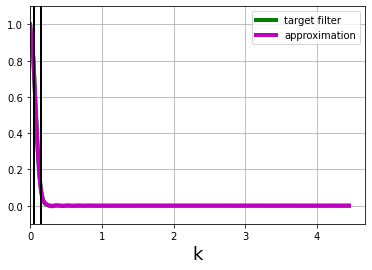

In [16]:
N=90

Lf = filter_fac/np.sqrt(6) 
NL90, sL90, NB90, sB90 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL90) + '; # Biharmonic steps: ' + str(NB90))

In [17]:
sL90

array([ 0.07117074,  0.11490557,  0.17203823,  0.24043497,  0.32008493,
        0.41092429,  0.51287439,  0.62584181,  0.74971826,  0.88438062,
        1.02969085,  1.18549614,  1.35162903,  1.52790769,  1.71413623,
        1.91010505,  2.11559121,  2.33035887,  2.55415967,  2.78673323,
        3.02780753,  3.27709937,  3.53431484,  3.79914977,  4.07129013,
        4.35041255,  4.63618475,  4.92826599,  5.22630754,  5.52995315,
        5.83883954,  6.15259681,  6.47084899,  6.79321447,  7.1193065 ,
        7.44873369,  7.78110047,  8.11600762,  8.45305271,  8.79183067,
        9.13193422,  9.47295442,  9.81448114, 10.15610357, 10.49741074,
       10.83799199, 11.1774375 , 11.51533877, 11.8512891 , 12.18488414,
       12.51572233, 12.84340538, 13.16753881, 13.48773236, 13.80360052,
       14.11476296, 14.42084499, 14.72147805, 15.0163001 , 15.30495611,
       15.58709844, 15.86238732, 16.1304912 , 16.39108718, 16.6438614 ,
       16.88850941, 17.12473656, 17.35225832, 17.57080064, 17.78

In [18]:
sB90

array([0.03545791-0.02117107j])

# Laplacian steps: 78; # Biharmonic steps: 1


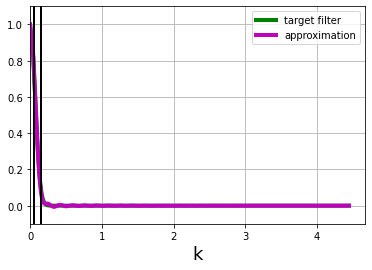

In [20]:
N=80

Lf = filter_fac/np.sqrt(6) 
NL80, sL80, NB80, sB80 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL80) + '; # Biharmonic steps: ' + str(NB80))

In [21]:
sL80

array([ 0.08648199,  0.14321112,  0.21434604,  0.29961752,  0.39897806,
        0.51234878,  0.63962165,  0.78065982,  0.93529806,  1.10334345,
        1.28457635,  1.47875143,  1.68559885,  1.90482532,  2.13611524,
        2.3791317 ,  2.63351751,  2.89889614,  3.17487263,  3.46103447,
        3.75695249,  4.06218168,  4.37626203,  4.69871938,  5.02906622,
        5.36680258,  5.7114168 ,  6.0623864 ,  6.41917895,  6.78125287,
        7.14805834,  7.51903815,  7.89362857,  8.27126024,  8.65135904,
        9.03334699,  9.41664315,  9.80066449, 10.18482684, 10.56854573,
       10.9512373 , 11.33231923, 11.7112116 , 12.08733779, 12.46012535,
       12.82900689, 13.19342095, 13.55281282, 13.90663546, 14.25435025,
       14.59542788, 14.92934912, 15.25560563, 15.57370071, 15.88315011,
       16.1834827 , 16.47424125, 16.75498309, 17.02528079, 17.28472282,
       17.53291417, 17.76947698, 17.99405106, 18.20629449, 18.40588411,
       18.59251604, 18.76590613, 18.92579036, 19.0719253 , 19.20

In [22]:
sB80

array([0.03833247-0.01232585j])

# Laplacian steps: 70; # Biharmonic steps: 0


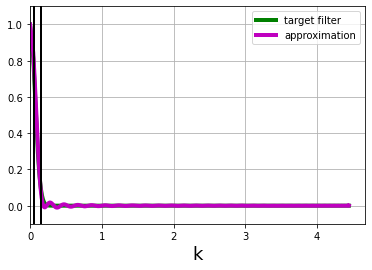

In [23]:
N=70

Lf = filter_fac/np.sqrt(6) 
NL70, sL70, NB70, sB70 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL70) + '; # Biharmonic steps: ' + str(NB70))

In [24]:
sL70

array([ 0.03379539,  0.05277558,  0.10988914,  0.18253214,  0.27347303,
        0.38273357,  0.51026882,  0.65596107,  0.81962648,  1.00102125,
        1.19984733,  1.41575741,  1.64835913,  1.8972186 ,  2.16186334,
        2.44178476,  2.73644031,  3.04525543,  3.36762533,  3.70291669,
        4.05046923,  4.40959736,  4.7795917 ,  5.15972066,  5.54923204,
        5.9473546 ,  6.35329967,  6.7662628 ,  7.18542534,  7.6099562 ,
        8.03901345,  8.47174604,  8.90729552,  9.34479778,  9.78338473,
       10.22218607, 10.66033102, 11.09695004, 11.5311766 , 11.96214887,
       12.38901145, 12.81091708, 13.22702832, 13.63651919, 14.03857686,
       14.43240323, 14.81721653, 15.19225287, 15.55676777, 15.91003761,
       16.25136111, 16.58006067, 16.89548378, 17.19700425, 17.48402352,
       17.75597178, 18.01230915, 18.25252676, 18.47614772, 18.68272808,
       18.87185775, 19.04316125, 19.19629852, 19.33096558, 19.44689511,
       19.5438571 , 19.62165936, 19.68014848, 19.71921432, 19.73

# Laplacian steps: 60; # Biharmonic steps: 0


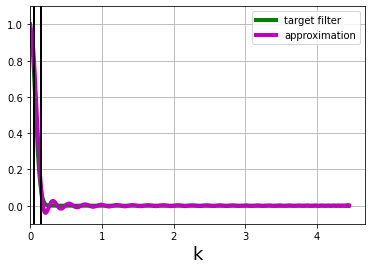

In [25]:
N=60

Lf = filter_fac/np.sqrt(6) 
NL60, sL60, NB60, sB60 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL60) + '; # Biharmonic steps: ' + str(NB60))

In [26]:
sL60

array([ 0.03222926,  0.07201832,  0.14366758,  0.23954295,  0.36032028,
        0.50606157,  0.67661902,  0.87168899,  1.09084615,  1.33356551,
        1.5992367 ,  1.88717346,  2.19662042,  2.52675816,  2.87670741,
        3.24553265,  3.6322455 ,  4.03580792,  4.45513545,  4.88910034,
        5.33653482,  5.7962344 ,  6.26696116,  6.74744722,  7.2363982 ,
        7.73249673,  8.23440603,  8.74077357,  9.25023474,  9.76141648,
       10.27294106, 10.78342979, 11.29150672, 11.79580236, 12.29495741,
       12.78762639, 13.2724813 , 13.74821516, 14.2135456 , 14.66721826,
       15.1080102 , 15.5347332 , 15.94623697, 16.34141221, 16.71919366,
       17.07856294, 17.41855129, 17.7382422 , 18.03677388, 18.31334158,
       18.56719975, 18.79766406, 19.00411328, 19.18599089, 19.34280669,
       19.47413808, 19.57963147, 19.6590039 , 19.71204953, 19.7392088 ])

# Laplacian steps: 50; # Biharmonic steps: 0


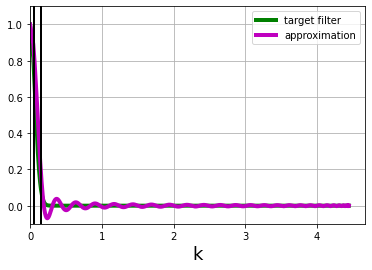

In [27]:
N=50

Lf = filter_fac/np.sqrt(6) 
NL50, sL50, NB50, sB50 = filterSpec(N, 1, Lf, 'Gaussian')
print('# Laplacian steps: ' + str(NL50) + '; # Biharmonic steps: ' + str(NB50))

In [28]:
sL50

array([ 0.03667099,  0.09709305,  0.19517686,  0.32922725,  0.49954643,
        0.70581634,  0.94740002,  1.2234449 ,  1.53292767,  1.8746768 ,
        2.24738574,  2.64962245,  3.07983726,  3.53637016,  4.01745799,
        4.52124172,  5.04577392,  5.58902647,  6.14889855,  6.72322481,
        7.30978385,  7.90630683,  8.51048624,  9.11998493,  9.73244508,
       10.3454974 , 10.95677026, 11.5638989 , 12.16453456, 12.7563536 ,
       13.33706646, 13.90442655, 14.45623891, 14.99036875, 15.50474966,
       15.99739165, 16.46638881, 16.90992672, 17.32628944, 17.71386617,
       18.07115749, 18.39678114, 18.68947739, 18.94811391, 19.17169021,
       19.35934154, 19.51034255, 19.62411111, 19.70021874, 19.7392088 ])

In [29]:
ds_f = xr.Dataset() # new xarray dataset for Gaussian-filtered fields
for fld in ds.dims:
    ds_f[fld] = ds[fld]

### Filter KE for all these different choices of N

The POP data lies on a B grid, and velocities in both x- and y-directions are given at "U-points".

In [30]:
data = ds['KE'].isel(time=0).copy() # Initialize the filtering process
data = data * ds['UAREA'] # multiply by cell area

#N=100
dataBar = apply_filter(data,wetu_mask, NL100, sL100, NB100, sB100)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE100'] = dataBar.copy()

#N=90
dataBar = apply_filter(data,wetu_mask, NL90, sL90, NB90, sB90)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE90'] = dataBar.copy()
  
#N=80
dataBar = apply_filter(data,wetu_mask, NL80, sL80, NB80, sB80)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE80'] = dataBar.copy()           

#N=70
dataBar = apply_filter(data,wetu_mask, NL70, sL70, NB70, sB70)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE70'] = dataBar.copy()   

#N=60
dataBar = apply_filter(data,wetu_mask, NL60, sL60, NB60, sB60)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE60'] = dataBar.copy()   

#N=50
dataBar = apply_filter(data,wetu_mask, NL50, sL50, NB50, sB50)
dataBar = xr.where(wetu_mask,dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['UAREA'] # divide by cell area  
ds_f['KE50'] = dataBar.copy() 

### Compare unfiltered and filtered KE

[Text(0.5, 1.0, 'filtered KE: 0.1 --> 5 degree, N=50')]

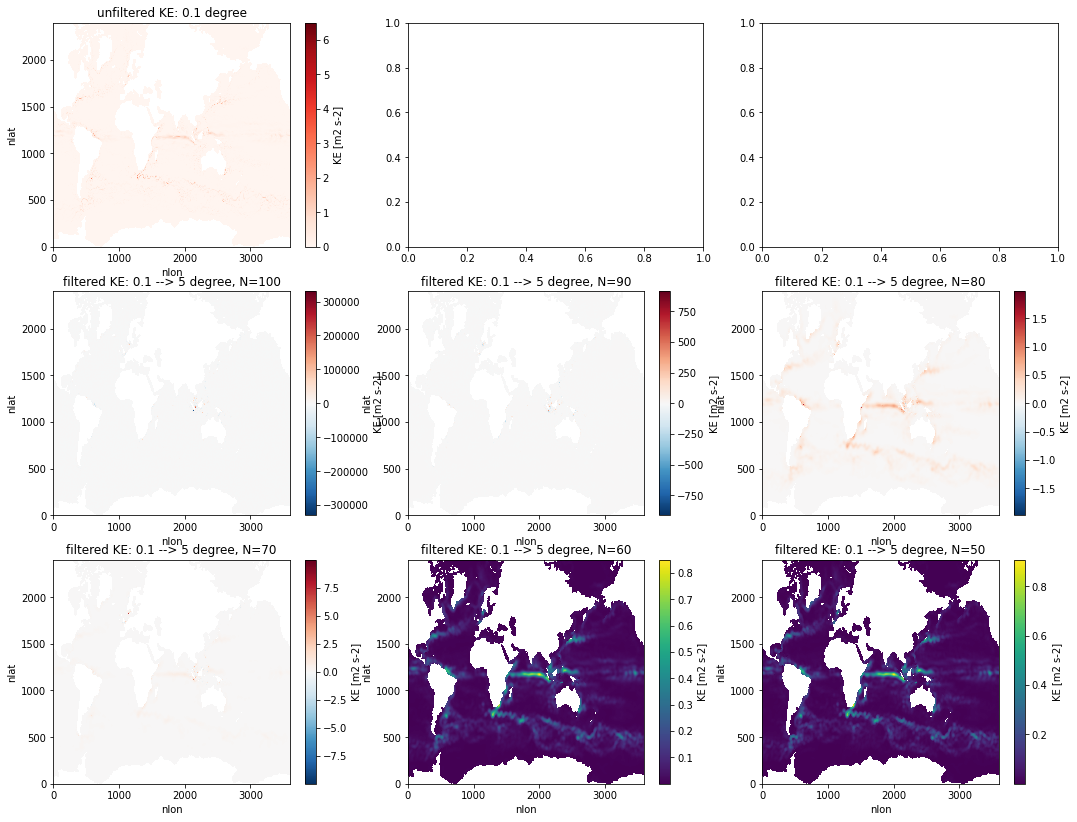

In [31]:
fig,axs = plt.subplots(3,3,figsize=(18,14))

(0.0001*ds['KE']).plot(ax=axs[0,0],cmap='Reds',cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE100']).plot(ax=axs[1,0],cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE90']).plot(ax=axs[1,1],cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE80']).plot(ax=axs[1,2],cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE70']).plot(ax=axs[2,0],cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE60']).plot(ax=axs[2,1],cbar_kwargs={"label":  'KE [m2 s-2]'})
(0.0001*ds_f['KE50']).plot(ax=axs[2,2],cbar_kwargs={"label":  'KE [m2 s-2]'})

axs[0,0].set(title='unfiltered KE: 0.1 degree')
axs[1,0].set(title='filtered KE: 0.1 --> 5 degree, N=100')
axs[1,1].set(title='filtered KE: 0.1 --> 5 degree, N=90')
axs[1,2].set(title='filtered KE: 0.1 --> 5 degree, N=80')
axs[2,0].set(title='filtered KE: 0.1 --> 5 degree, N=70')
axs[2,1].set(title='filtered KE: 0.1 --> 5 degree, N=60')
axs[2,2].set(title='filtered KE: 0.1 --> 5 degree, N=50')

Filtering with high N seems to be unstable, and generates values of really large amplitude. Let's have a closer look, and zoom into a region in the Atlantic:

[Text(0, 0.5, ''), Text(0.5, 1.0, 'filtered KE: 0.1 --> 5 degree, N=100')]

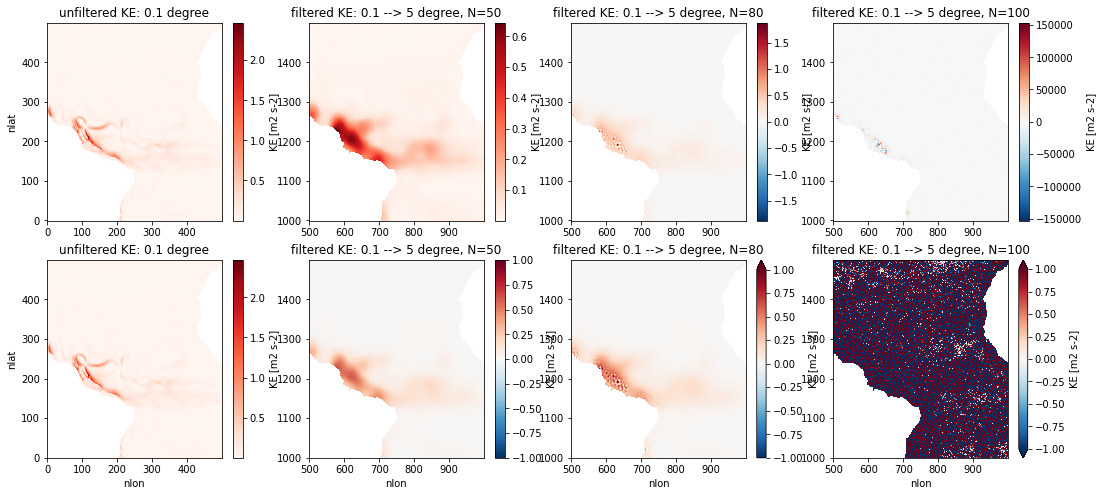

In [32]:
xslice = slice(500,1000)
yslice = slice(1000,1500)
vmax = 2
vmin = -2

fig,axs = plt.subplots(2,4,figsize=(18,8))
(0.0001*ds['KE']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,0],cmap='Reds',cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[0,0].set(title='unfiltered KE: 0.1 degree',xlabel='')

(0.0001*ds_f['KE50']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,1],cmap='Reds',
                                                              cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[0,1].set(title='filtered KE: 0.1 --> 5 degree, N=50',xlabel='',ylabel='')

(0.0001*ds_f['KE80']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,2],cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[0,2].set(title='filtered KE: 0.1 --> 5 degree, N=80',xlabel='',ylabel='')

(0.0001*ds_f['KE100']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[0,3],cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[0,3].set(title='filtered KE: 0.1 --> 5 degree, N=100',xlabel='',ylabel='')

(0.0001*ds['KE']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,0],cmap='Reds',cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[1,0].set(title='unfiltered KE: 0.1 degree')

(0.0001*ds_f['KE50']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,1],cmap='RdBu_r',vmin=-1,vmax=1,
                                                              cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[1,1].set(title='filtered KE: 0.1 --> 5 degree, N=50',ylabel='')

(0.0001*ds_f['KE80']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,2],cmap='RdBu_r',vmin=-1,vmax=1,
                                                         cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[1,2].set(title='filtered KE: 0.1 --> 5 degree, N=80',ylabel='')

(0.0001*ds_f['KE100']).isel(nlon=xslice,nlat=yslice).plot(ax=axs[1,3],cmap='RdBu_r',vmin=-1,vmax=1,
                                                          cbar_kwargs={"label":  'KE [m2 s-2]'})
axs[1,3].set(title='filtered KE: 0.1 --> 5 degree, N=100',ylabel='')


I'm not exactly sure what causes the instabilities for large N. Have to look more into this.